# Regras de associação - Apriori

## 1. Introdução

### 1.1 Importação e carga do dataset

In [2]:
import sklearn
import pandas as pd
import numpy as np

In [3]:
dfs = pd.read_csv('mercado2.csv', sep=';'  , engine='python', header=None)

### 1.2 Análise das compras por transação

In [4]:
dfs['qt_itens']  = len(dfs[0].str.split(",").tolist()[0])

In [5]:
for i in range(0,len(dfs)):
    dfs['qt_itens'].iloc[i] = len(dfs.iloc[i].str.split(",").tolist()[0])

/home/jp/.local/lib/python3.6/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


In [6]:
dfs.head()

,0,qt_itens
0,"shrimp,almonds,avocado,vegetables mix,green gr...",20
1,"burgers,meatballs,eggs",3
2,chutney,1
3,"turkey,avocado",2
4,"mineral water,milk,energy bar,whole wheat rice...",5


In [7]:
dfs.describe()

,qt_itens
count,7501.000000
mean,3.914545
std,2.905540
min,1.000000
25%,2.000000
50%,3.000000
75%,5.000000
max,20.000000


## 2. Regras de associação  - algoritmo Apriori

In [8]:
from apyori import apriori

### 2.1 Preparação dos dados para o algoritmo

In [9]:
transactions = dfs.values.tolist()

In [10]:
dfs = dfs[0].str.split(",", expand = True)

In [11]:
dfs.fillna(0,inplace=True)

In [12]:
dfs.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
0,shrimp,almonds,avocado,vegetables mix,green grapes,whole weat flour,yams,cottage cheese,energy drink,tomato juice,low fat yogurt,green tea,honey,salad,mineral water,salmon,antioxydant juice,frozen smoothie,spinach,olive oil
1,burgers,meatballs,eggs,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,chutney,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,turkey,avocado,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,mineral water,milk,energy bar,whole wheat rice,green tea,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [13]:
transactions = []
for i in range(0,len(dfs)):
    transactions.append([str(dfs.values[i,j]) for j in range(0,20) if str(dfs.values[i,j])!='0'])

### 2.2 Execução do algoritmo Apriori

#### 2.2.1 Iteração 1 - parâmetros: suporte mínimo - 0.01 e confiança mínima - 0.2

In [152]:
rules = apriori(transactions, min_support = 0.01, min_confidence = 0.2)

In [153]:
#Support degree (support), first enter an empty list, and then assign
supports=[]
#Confidence
confidences=[]
#Lift
lifts=[]
#Based on items_base
bases=[]
#Derivation items items_add
adds=[]

In [154]:
for r in rules:
    for x in r.ordered_statistics:
        supports.append(r.support)
        confidences.append(x.confidence)
        lifts.append(x.lift)
        bases.append(list(x.items_base))
        adds.append(list(x.items_add))

In [155]:
df_result = pd.DataFrame({
    'support':supports,
    'confidence':confidences,
    'lift':lifts,
    'base':bases,
    'adds':adds
})

##### OBS.: Excluindo os resultados com apenas 1 item (compra de apenas 1 item)

In [156]:
df_result = df_result[(df_result.base.str.len() >= 1)]

#### 2.2.1.1 Resumo do suporte, confiança e lift

In [157]:
df_result.describe()

,support,confidence,lift
count,162.000000,162.000000,162.000000
mean,0.020105,0.288604,1.640048
std,0.010826,0.075359,0.370420
min,0.010132,0.200306,0.902495
25%,0.012665,0.228827,1.359001
50%,0.016398,0.265724,1.572121
75%,0.023030,0.332569,1.855226
max,0.059725,0.506667,3.291994


In [158]:
import matplotlib.pyplot as plt

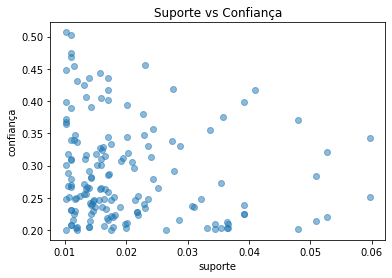

In [160]:
plt.scatter(df_result.support, df_result.confidence, alpha=0.5)
plt.xlabel('suporte')
plt.ylabel('confiança')
plt.title('Suporte vs Confiança')
plt.show()

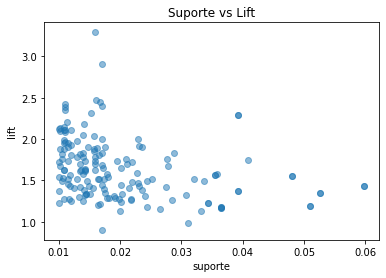

In [161]:
plt.scatter(df_result.support, df_result.lift, alpha=0.5)
plt.xlabel('suporte')
plt.ylabel('lift')
plt.title('Suporte vs Lift')
plt.show()

In [208]:
base_value_counts =  df_result['base'].value_counts()
# converting to df and assigning new names to the columns
df_freq_base = pd.DataFrame(base_value_counts)
df_freq_base = df_freq_base.reset_index()
df_freq_base.columns = ['antecedente', 'freq'] # change column names

<AxesSubplot:xlabel='antecedente'>

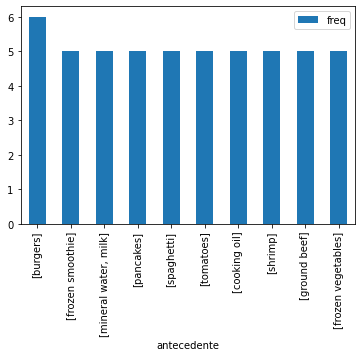

In [209]:
df_freq_base.sort_values(by=['freq'], ascending=False).head(10).plot(kind='bar',x='antecedente',y='freq')

In [206]:
adds_value_counts =  df_result['adds'].value_counts()
# converting to df and assigning new names to the columns
df_freq_adds = pd.DataFrame(adds_value_counts)
df_freq_adds = df_freq_adds.reset_index()
df_freq_adds.columns = ['consequente', 'freq'] # change column names

<AxesSubplot:xlabel='consequente'>

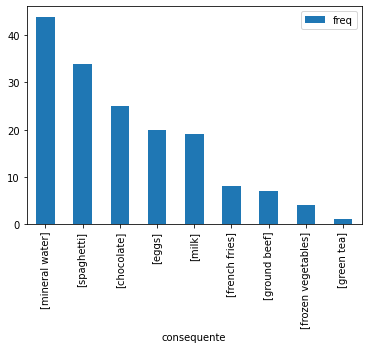

In [207]:
df_freq_adds.sort_values(by=['freq'], ascending=False).head(10).plot(kind='bar',x='consequente',y='freq')

##### // (df_result.support > 0.015) & (df_result.confidence > 0.28) & (df_result.lift > 1.7)

#### 2.2.1.2 Filtro dos primeiros 30 resultados, ordenados em ordem decrescente de support, confidence, lift

In [142]:
df_result.sort_values(by=['support','confidence','lift'], ascending=False).head(30)

,support,confidence,lift,base,adds
103,0.059725,0.343032,1.439085,[spaghetti],[mineral water]
102,0.059725,0.250559,1.439085,[mineral water],[spaghetti]
29,0.052660,0.321400,1.348332,[chocolate],[mineral water]
30,0.052660,0.220917,1.348332,[mineral water],[chocolate]
51,0.050927,0.283383,1.188845,[eggs],[mineral water]
52,0.050927,0.213647,1.188845,[mineral water],[eggs]
87,0.047994,0.370370,1.553774,[milk],[mineral water]
88,0.047994,0.201342,1.553774,[mineral water],[milk]
78,0.040928,0.416554,1.747522,[ground beef],[mineral water]
80,0.039195,0.398915,2.291162,[ground beef],[spaghetti]


#### 2.2.1.2 Filtro dos primeiros 10 resultados, ordenados em ordem crescente de lift, support, confidence

In [210]:
df_result.sort_values(by=['lift','support','confidence'], ascending=[True,False,False]).head(10)

,support,confidence,lift,base,adds
58,0.017064,0.215126,0.902495,[escalope],[mineral water]
74,0.031063,0.235116,0.986357,[green tea],[mineral water]
20,0.033196,0.202604,1.127397,[chocolate],[eggs]
47,0.019997,0.203528,1.132539,[ground beef],[eggs]
75,0.026530,0.200807,1.153335,[green tea],[spaghetti]
55,0.036528,0.209801,1.167446,[spaghetti],[eggs]
54,0.036528,0.203264,1.167446,[eggs],[spaghetti]
6,0.024397,0.279817,1.173883,[burgers],[mineral water]
45,0.036395,0.212949,1.184961,[french fries],[eggs]
44,0.036395,0.202522,1.184961,[eggs],[french fries]


#### 2.2.2 Iteração 2 - parâmetros: suporte mínimo - 0.03, confiança mínima - 0.35 e lift mínimo - 1.1

In [144]:
rules = apriori(transactions, min_support = 0.035, min_confidence = 0.35, min_lift = 1.1)

In [145]:
#Support degree (support), first enter an empty list, and then assign
supports=[]
#Confidence
confidences=[]
#Lift
lifts=[]
#Based on items_base
bases=[]
#Derivation items items_add
adds=[]

In [146]:
for r in rules:
    for x in r.ordered_statistics:
        supports.append(r.support)
        confidences.append(x.confidence)
        lifts.append(x.lift)
        bases.append(list(x.items_base))
        adds.append(list(x.items_add))

In [147]:
df_result = pd.DataFrame({
    'support':supports,
    'confidence':confidences,
    'lift':lifts,
    'base':bases,
    'adds':adds
})

##### OBS.: Excluindo os resultados com apenas 1 item (compra de apenas 1 item)

In [148]:
df_result = df_result[(df_result.base.str.len() >= 1) | (df_result.adds.str.len() >= 1)]

#### Filtro dos primeiros 30 resultados, ordenados em ordem decrescente de support, confidence, lift

In [149]:
df_result.sort_values(by=['support','confidence','lift'], ascending=False).head(30)

,support,confidence,lift,base,adds
3,0.047994,0.370370,1.553774,[milk],[mineral water]
1,0.040928,0.416554,1.747522,[ground beef],[mineral water]
2,0.039195,0.398915,2.291162,[ground beef],[spaghetti]
0,0.035729,0.374825,1.572463,[frozen vegetables],[mineral water]
